# Loan Defaulter Classifier

In consumer finance, lending money is a delicate balance between opportunity and risk. Loan providing companies often face challenges in lending to individuals with insufficient or non-existent credit history, thus facing the challenge of identifying potential customers who can responsibly manage their loans. This project aims to tackle that challenge by analysing historical data to identify patterns that can help predict which applicants are likely to default on their loans.

The lack of credit history information can lead to adverse outcomes, where some consumers exploit the situation and become defaulters. In this context, our project addresses two critical risks associated with loan approval decisions:
* Opportunity Loss: Failing to approve loans for applicants who are capable of repaying them results in missed business opportunities.
* Financial Loss: Approving loans for applicants likely to default can lead to significant financial losses for the company.

*PS: We would strongly recommend using the headings sections of this notebook on Jupyter Lab/Notebook for easier accessibility.*

## Team Members
* Shruti Gajipara 121233882 shruti01@umd.edu
* Aayush Verma 121331076 aver23@umd.edu
* Premal Shah 121293596 shah1305@umd.edu
* Asutosh Dalei 120997754 asutoshd@umd.edu

In [264]:
!pip install catboost --quiet

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict

import os
import warnings
warnings.filterwarnings('ignore')

In [266]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.svm import OneClassSVM, SVC
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.ensemble import RandomForestClassifier

## Datasets

In [267]:
# from google.colab import drive
# drive.mount("/content/drive")

In [268]:
# dataPath = "/content/drive/MyDrive/Datasets/Loan-Defaulter-Classification"
# os.listdir(dataPath)

In [269]:
colDesPath = r'columns_description.csv'
appliPath = r'application_data.csv'
prevAppliPath = r'previous_application.csv'

# colDesPath = 'columns_description.csv'
# appliPath = 'application_data.csv'
# prevAppliPath = 'previous_application.csv'

# # colDesPath = r'/content/drive/MyDrive/Datasets/Loan-Defaulter-Classification/columns_description.csv'
# # appliPath = r'/content/drive/MyDrive/Datasets/Loan-Defaulter-Classification/application_data.csv'
# # prevAppliPath = r'/content/drive/MyDrive/Datasets/Loan-Defaulter-Classification/previous_application.csv'


# for i in [colDesPath,appliPath,prevAppliPath]:
#     print(str(i),":",os.path.getsize(i)/1e6,'mb')

# for i in [colDesPath,appliPath,prevAppliPath]:
#     print(str(i),":",os.path.getsize(i)/1e6,'mb')

In [270]:
%%time
columnDescription = pd.read_csv(colDesPath).drop(columns = ['Unnamed: 0'])
columnDescription.head()

CPU times: user 4 ms, sys: 998 µs, total: 4.99 ms
Wall time: 5.81 ms


,Table,Row,Description,Special
0,application_data,SK_ID_CURR,ID of loan in our sample,NaN
1,application_data,TARGET,Target variable (1 - client with payment diffi...,NaN
2,application_data,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,application_data,CODE_GENDER,Gender of the client,NaN
4,application_data,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [271]:
columnDescription.Table.value_counts()

,count
Table,
application_data,122
previous_application.csv,38


In [272]:
%%time
appData = pd.read_csv(appliPath)
print(appData.shape)
appData.head()

(307511, 122)
CPU times: user 5.08 s, sys: 753 ms, total: 5.83 s
Wall time: 10.7 s


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [273]:
defiFnx = lambda col,table='application_data': columnDescription[(columnDescription.Row == col) & (columnDescription.Table==table)]['Description'].item()

## Initial EDA, Primary Preprocessing & Data Manipulation

**Based out on prior EDA work**

In this stage, we will perform the following preprocessing tasks:

- **Handle missing values**: Impute or remove missing data based on feature type.
- **Feature engineering**: Create new features if necessary (e.g., interaction terms or polynomial features).
- **Feature selection**: Remove highly correlated or irrelevant features to reduce dimensionality.

These steps aim to transform the data into a suitable format for modeling.


### Columns with missing data

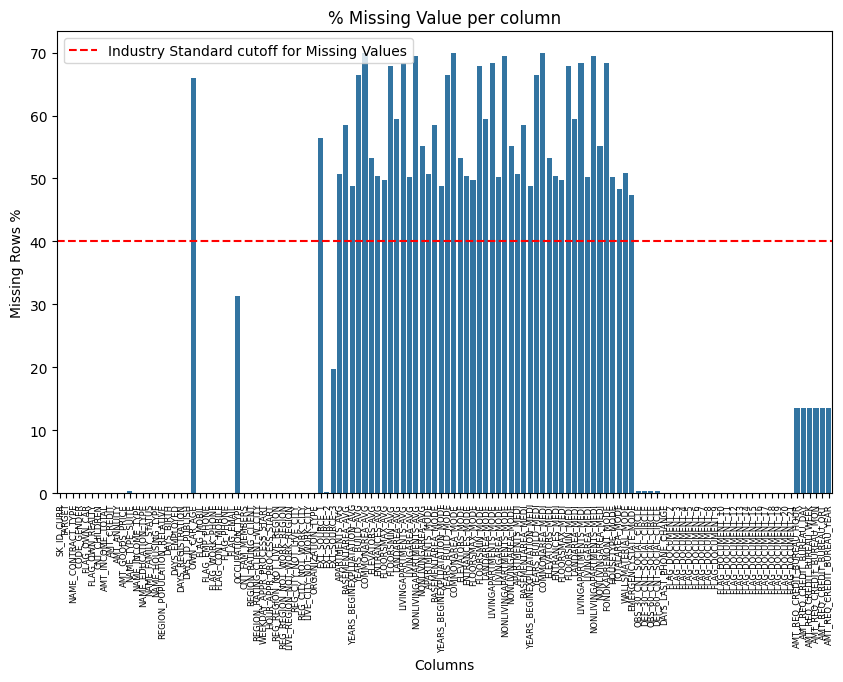

In [274]:
plt.figure(figsize=(10,6),dpi=100)
sns.barplot(data=appData.isna().mean()*100)
plt.axhline(y=40,color='red',linestyle = '--',label='Industry Standard cutoff for Missing Values')
plt.legend()
plt.xticks(rotation=90,fontsize=6)
plt.title('% Missing Value per column')
plt.xlabel('Columns')
plt.ylabel('Missing Rows %')
plt.show()

In [275]:
# Feature Creation: missingData. To indicate the % of datapoints missing in the row.
appData = appData.assign(missingData = appData.isna().mean(axis=1)*100)

### Relation between % of missing data in each row v/s the chance of defaulting

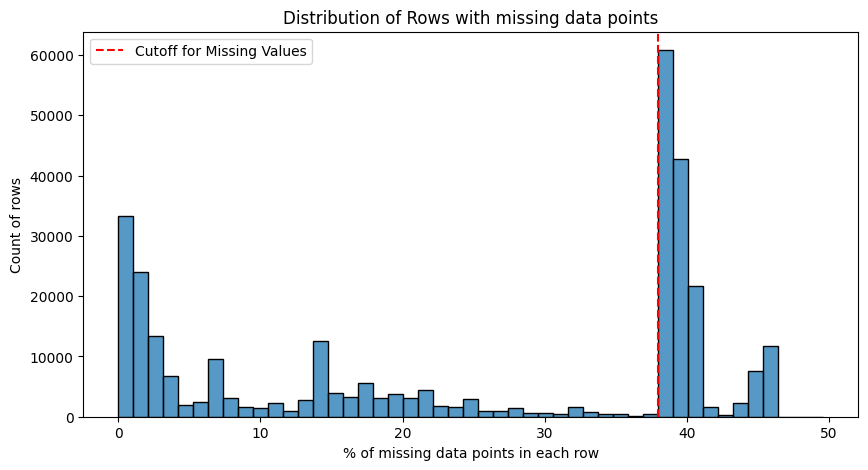

In [276]:
plt.figure(figsize=(10,5),dpi=100)
sns.histplot(appData.isna().mean(axis=1)*100)
plt.axvline(x=38,color='red',linestyle = '--',label='Cutoff for Missing Values')
plt.title('Distribution of Rows with missing data points')
plt.xlabel('% of missing data points in each row')
plt.ylabel('Count of rows')
plt.legend()
plt.show()

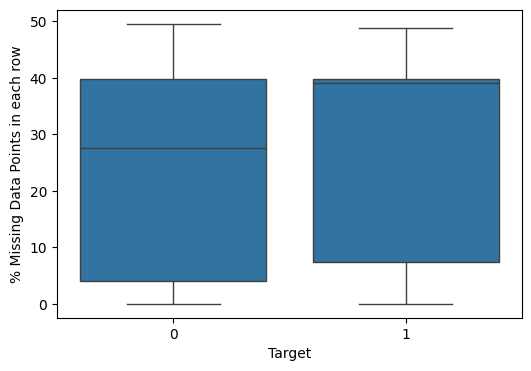

In [277]:
plt.figure(figsize=(6,4),dpi=100)
sns.boxplot(y = appData.isna().mean(axis=1)*100,x=appData.TARGET,showfliers=False)
plt.xlabel('Target')
plt.ylabel("% Missing Data Points in each row")
plt.show()

### Regional Impact

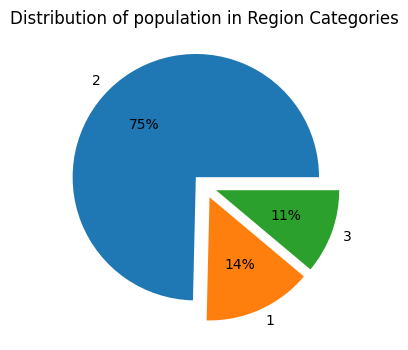

In [278]:
regCols = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
plt.figure(figsize=(5,4),dpi=100)
plt.pie(appData['REGION_RATING_CLIENT_W_CITY'].value_counts(),labels=appData['REGION_RATING_CLIENT_W_CITY'].unique(),explode=[0.1, 0.1, 0.1] ,autopct='%.0f%%')
plt.title("Distribution of population in Region Categories")
plt.show()

<Figure size 500x400 with 0 Axes>

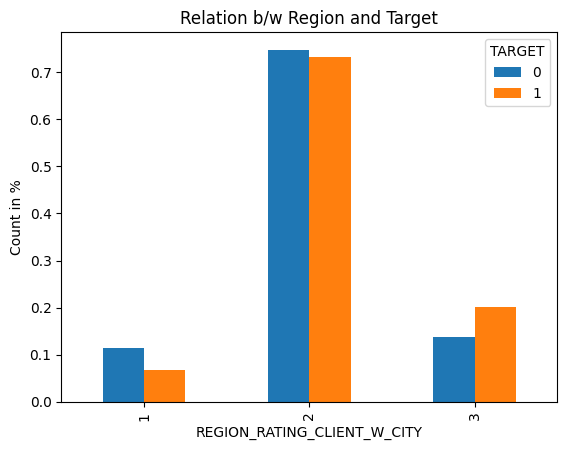

In [279]:
# Doesn't seem like a heavy relation.
plt.figure(figsize=(5,4),dpi=100)
pd.crosstab(appData['REGION_RATING_CLIENT_W_CITY'], appData['TARGET'],normalize='columns').plot(kind='bar')
plt.title("Relation b/w Region and Target")
plt.ylabel("Count in %")
plt.show()

In [280]:
%%time
regCols = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
appData['region'] = appData[regCols].mean(axis=1)
appData.drop(columns = regCols, inplace=True)

CPU times: user 147 ms, sys: 103 ms, total: 249 ms
Wall time: 593 ms


In [281]:
def feature_analyze(feature,ylog=False,label_rotation=False,horizontal_layout=True):
    temp = appData[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    cat_perc = appData[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc["TARGET"] = cat_perc["TARGET"]*100
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,24))
    s = sns.countplot(ax=ax1,
                    x = feature,
                    data=appData,
                    hue ="TARGET",
                    order=cat_perc[feature],
                    palette=['black','r'])
    ax1.set_title(feature, fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'})
    ax1.legend(['Repayer','Defaulter'])
    if ylog:
        ax1.set_yscale('log')
        ax1.set_ylabel("Count",fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Black'})
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)

    s = sns.barplot(ax=ax2,
                    x = feature,
                    y='TARGET',
                    order=cat_perc[feature],
                    data=cat_perc,
                    palette='Set1')
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of Defaulters [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    ax2.set_title("Defaulter % across " +feature, fontdict={'fontsize' : 15, 'fontweight' : 5, 'color' : 'Black'})
    plt.show();

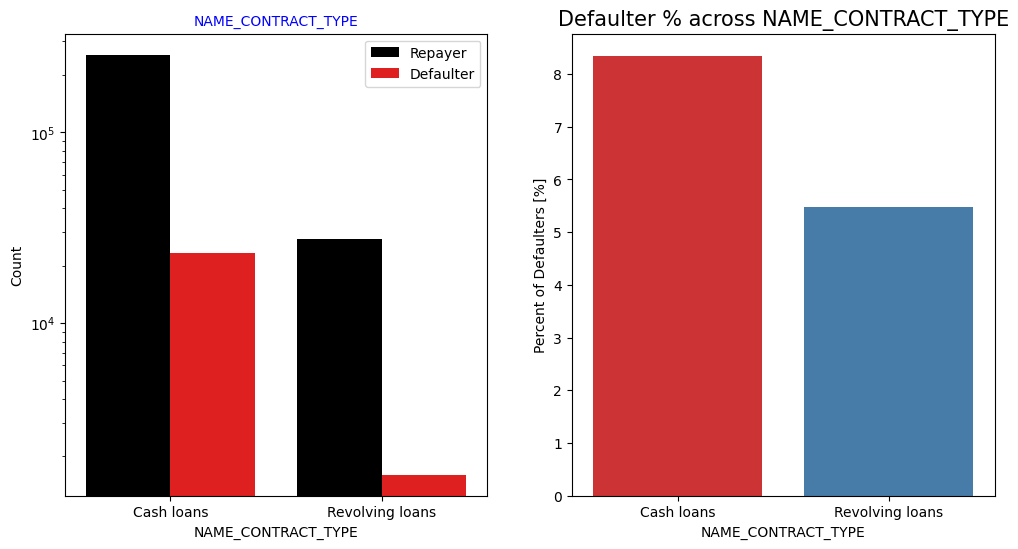

In [282]:
feature_analyze('NAME_CONTRACT_TYPE',True)

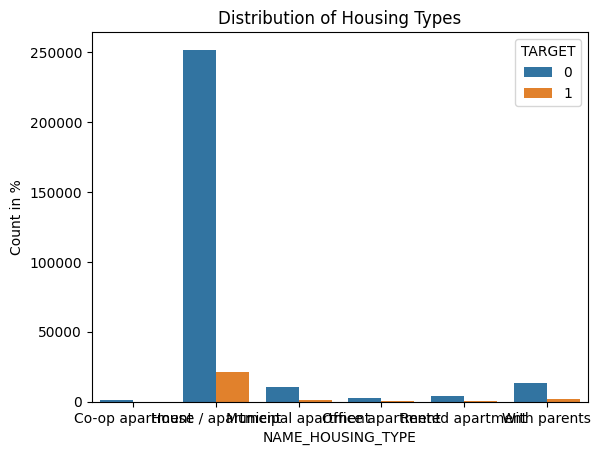

In [283]:
df1=appData.groupby('NAME_HOUSING_TYPE')['TARGET'].value_counts()
sns.barplot(x=df1.index.get_level_values(0),y=df1.values,hue=df1.index.get_level_values(1))
plt.title("Distribution of Housing Types")
plt.ylabel("Count in %")
plt.show()


Analysing the distribution of Loan Amounts

In [284]:
appData['AMT_CREDIT']=appData['AMT_CREDIT']/100000

In [285]:
bins = [0,1,2,3,4,5,6,7,8,9,10,100]
slots = ['0-100K','100K-200K', '200k-300k','300k-400k','400k-500k','500k-600k','600k-700k','700k-800k',
       '800k-900k','900k-1M', '1M Above']

appData['AMT_CREDIT_RANGE']=pd.cut(appData['AMT_CREDIT'],bins=bins,labels=slots)

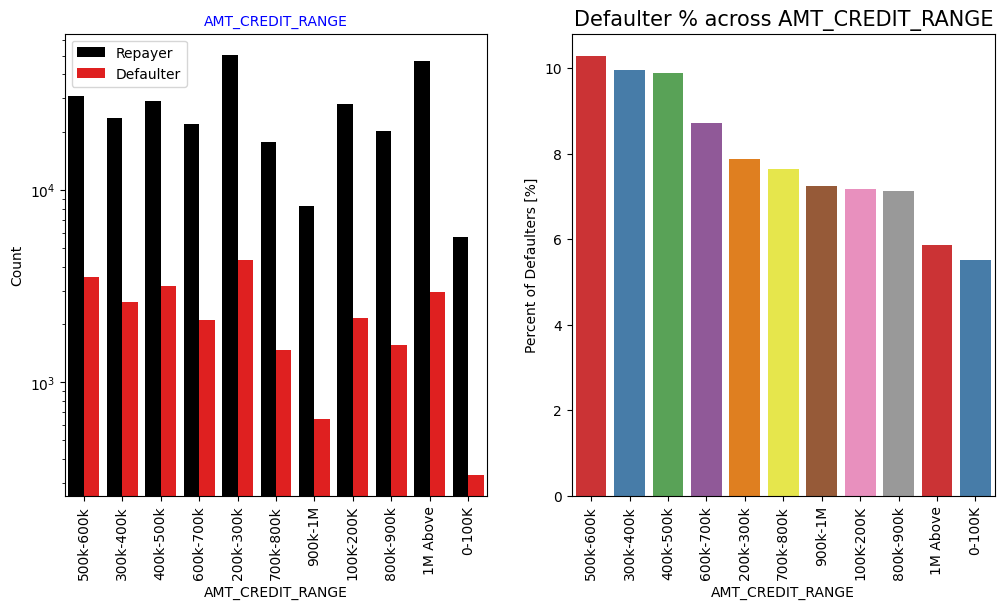

In [286]:
feature_analyze('AMT_CREDIT_RANGE',True,True,True)

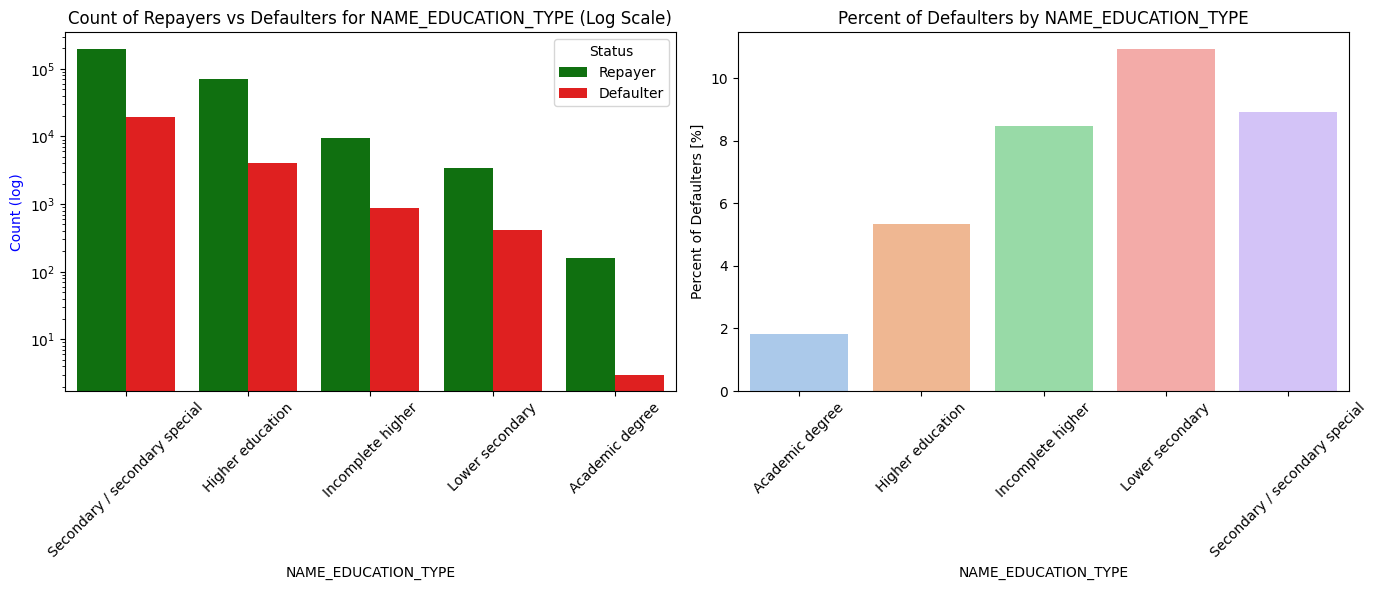

In [287]:

def education_analysis(df, feature, target):
    value_counts = df[feature].value_counts().index
    target_mean = df.groupby(feature)[target].mean() * 100
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

    sns.countplot(x=feature,
                  data=df,
                  hue=target,
                  order=value_counts,
                  palette=['green', 'red'],
                  ax=ax1)
    ax1.set_yscale('log')
    ax1.set_title(f"Count of Repayers vs Defaulters for {feature} (Log Scale)", fontsize=12, color='black')
    ax1.set_ylabel("Count (log)", fontsize=10, color='blue')
    ax1.legend(title='Status', labels=['Repayer', 'Defaulter'])
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

    sns.barplot(x=target_mean.index,
                y=target_mean.values,
                palette='pastel',
                ax=ax2)
    ax2.set_title(f"Percent of Defaulters by {feature}", fontsize=12, color='black')
    ax2.set_ylabel("Percent of Defaulters [%]", fontsize=10)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()


education_analysis(appData, 'NAME_EDUCATION_TYPE', 'TARGET')


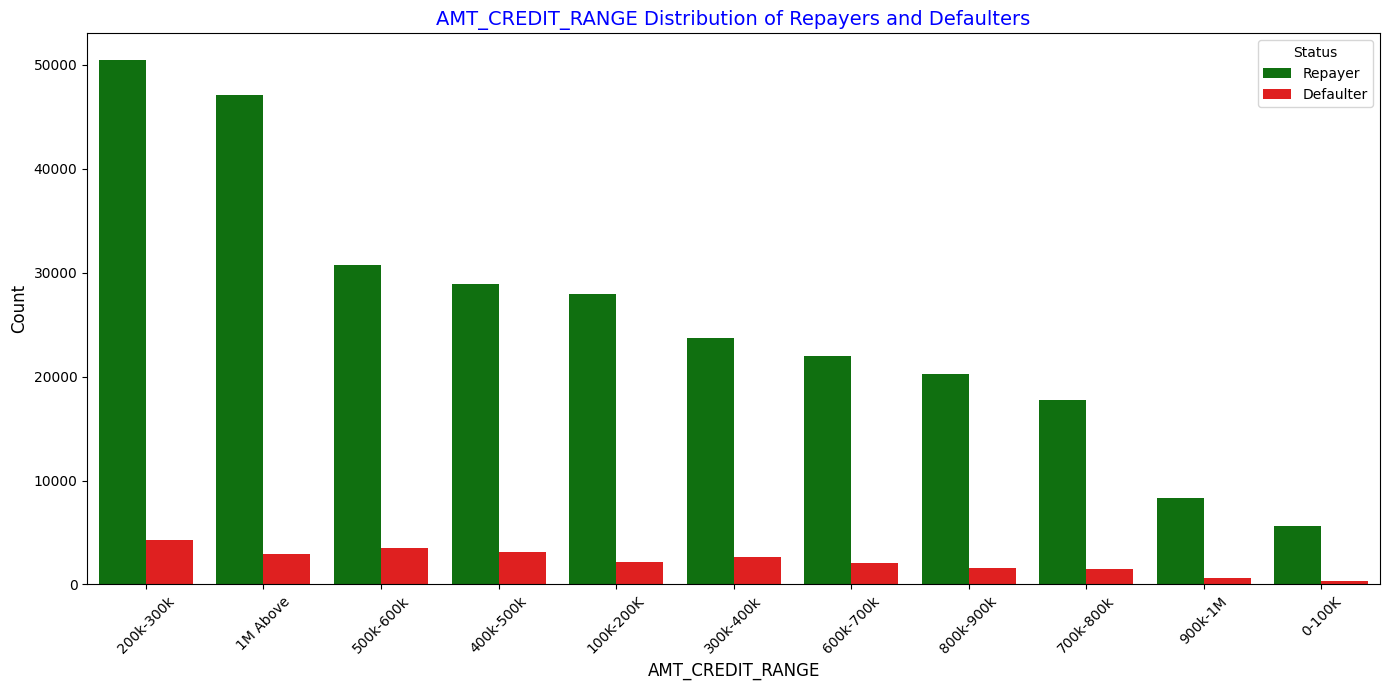

In [288]:
value_counts = appData['AMT_CREDIT_RANGE'].value_counts().index

plt.figure(figsize=(14, 7))
sns.countplot(x='AMT_CREDIT_RANGE',
                  data=appData,
                  hue='TARGET',
                  order=value_counts,
                  palette=['green', 'red'])

plt.title(f"{'AMT_CREDIT_RANGE'} Distribution of Repayers and Defaulters", fontsize=14, color='blue')
plt.ylabel("Count", fontsize=12)
plt.xlabel('AMT_CREDIT_RANGE', fontsize=12)
plt.legend(title="Status", labels=["Repayer", "Defaulter"], loc="upper right")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Amount Credit

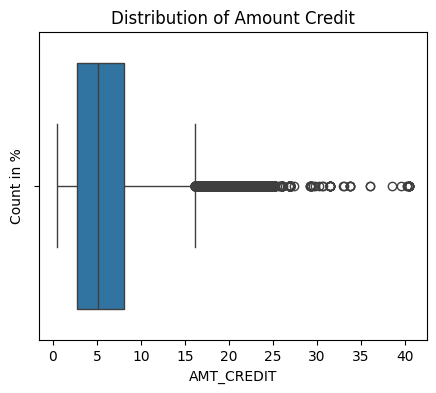

In [289]:
plt.figure(figsize=(5,4),dpi=100)
sns.boxplot(appData['AMT_CREDIT'],orient='h')
plt.title("Distribution of Amount Credit")
plt.ylabel("Count in %")
plt.show()

In [290]:
%%time
amtCols = [col for col in appData.columns if 'AMT_REQ_CREDIT_BUREAU' in col]
appData['creditB'] = appData[amtCols].sum(axis=1)
appData.drop(columns = amtCols, inplace=True)

CPU times: user 172 ms, sys: 97.2 ms, total: 269 ms
Wall time: 866 ms


### Employment

In [291]:
# Correcting DAYS_EMPLOYED to work experience
appData['workExperience'] = (-appData['DAYS_EMPLOYED']/365).astype('float')
appData.drop(columns=['DAYS_EMPLOYED'],inplace=True)

#Number of cases where workExperience is less that 0. Since that is not possible, we will replace those rows with 0.
print("Number of cases with workEx < 0:", appData[appData['workExperience'] < 0].shape[0])

idx = appData[appData['workExperience'] < 0].index
appData.iloc[idx,appData.columns.get_loc('workExperience')] = 0

print("Number of cases with workEx < 0 after trasformation:", appData[appData['workExperience'] < 0].shape[0])

Number of cases with workEx < 0: 55374
Number of cases with workEx < 0 after trasformation: 0


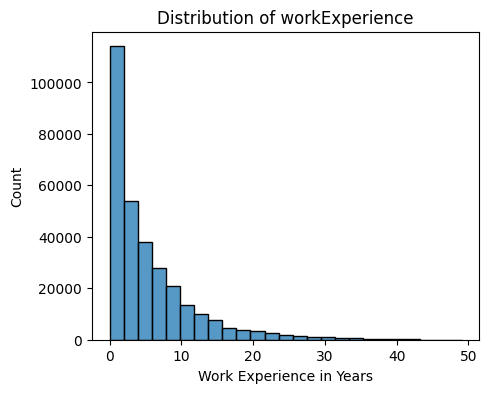

In [292]:
# appData['workExperience'].dtype
plt.figure(figsize=(5,4),dpi=100)
sns.histplot(data=appData,x='workExperience',binwidth = 2)
plt.title("Distribution of workExperience")
plt.xlabel('Work Experience in Years')
plt.show()

In [293]:
# Dropping rows with wrong gender
appData = appData[appData['CODE_GENDER'] != 'XNA']

In [294]:
%%time
commCols = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']
appData['mobileCommunication'] = appData[commCols].sum(axis=1)#/len(commCols)
appData.drop(columns = commCols, inplace=True)

CPU times: user 152 ms, sys: 169 ms, total: 321 ms
Wall time: 664 ms


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'Laborers'),
  Text(1, 0, 'Core staff'),
  Text(2, 0, 'Accountants'),
  Text(3, 0, 'Managers'),
  Text(4, 0, 'Drivers'),
  Text(5, 0, 'Sales staff'),
  Text(6, 0, 'Cleaning staff'),
  Text(7, 0, 'Cooking staff'),
  Text(8, 0, 'Private service staff'),
  Text(9, 0, 'Medicine staff'),
  Text(10, 0, 'Security staff'),
  Text(11, 0, 'High skill tech staff'),
  Text(12, 0, 'Waiters/barmen staff'),
  Text(13, 0, 'Low-skill Laborers'),
  Text(14, 0, 'Realty agents'),
  Text(15, 0, 'Secretaries'),
  Text(16, 0, 'IT staff'),
  Text(17, 0, 'HR staff')])

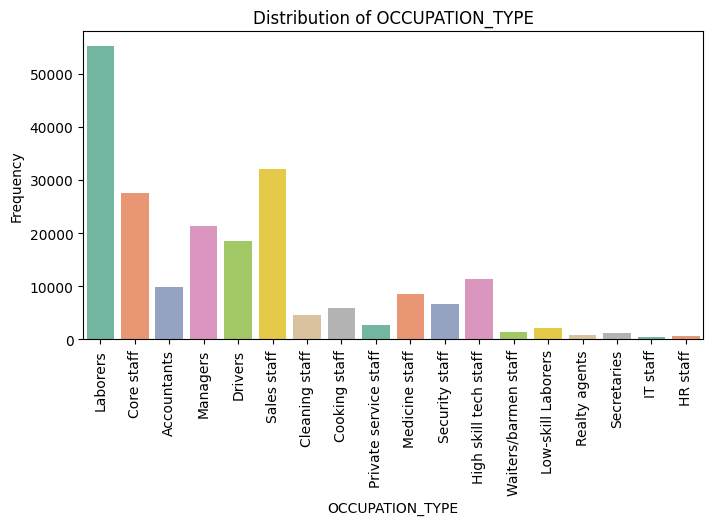

In [295]:
plt.figure(figsize=(8, 4))
sns.countplot(x=appData['OCCUPATION_TYPE'],data=appData,palette='Set2')
plt.title(f'Distribution of OCCUPATION_TYPE')
plt.xlabel('OCCUPATION_TYPE')
plt.ylabel('Frequency')
plt.xticks(rotation=90)


In [296]:
docCols = [col for col in appData.columns  if 'DOCU' in col]
dropCols = []
for i in docCols:
    if i != 'FLAG_DOCUMENT_3':
        dropCols.append(i)
appData.drop(columns = dropCols, inplace=True)

In [297]:
idx = appData[appData['OWN_CAR_AGE'].notna()].index
appData.loc[idx,'OWN_CAR_AGE'] = 1

### Columns with missing Data

In [298]:
missingDataCol = appData.isna().mean()
missingDataCol[missingDataCol>0.4].head()

,0
OWN_CAR_AGE,0.659910
EXT_SOURCE_1,0.563812
APARTMENTS_AVG,0.507501
BASEMENTAREA_AVG,0.585164
YEARS_BEGINEXPLUATATION_AVG,0.487813


In [299]:
morethan_40percent_missing = missingDataCol[(missingDataCol>0.4)].index.tolist()
print(morethan_40percent_missing)

['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE

### Realty Columns
* These columns are linked to housing details of applicants.
* The columns have a missing data percentage of more than 40 % and have poor correlation with the TARGET variable.
* Will be dropping them.

In [300]:
realty_ = []
for i in morethan_40percent_missing:
    if 'AVG' in i:
        realty_.append(i)
realty_

['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG']

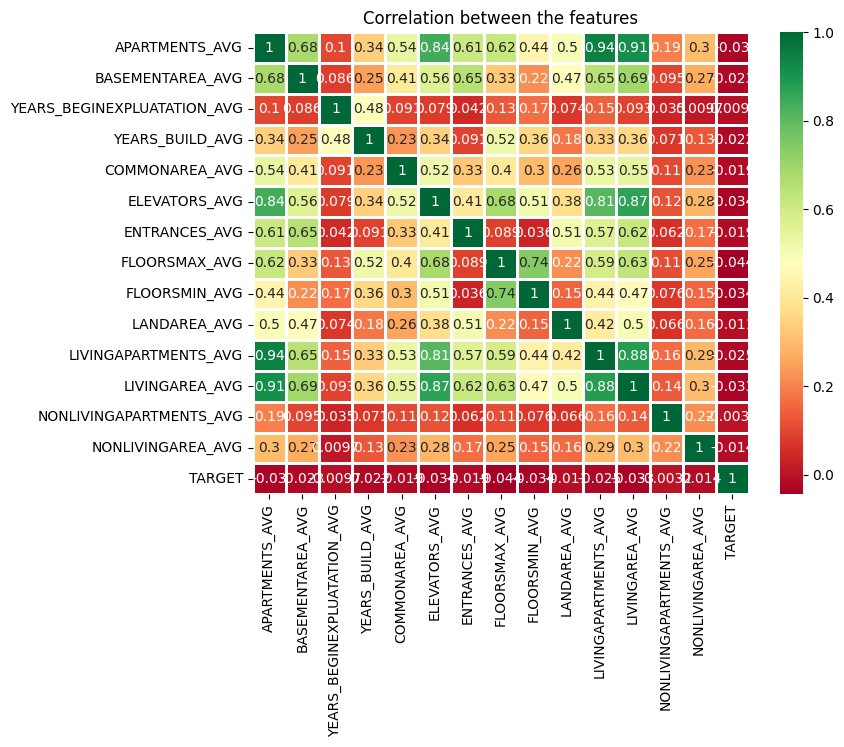

In [301]:
suspect_col = realty_ + ['TARGET']
suspect_corr = appData[suspect_col].corr()
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(suspect_corr,xticklabels=suspect_corr.columns,yticklabels=suspect_corr.columns,annot = True,cmap ="RdYlGn",linewidth=1)
plt.title("Correlation between the features")
plt.show()

In [302]:
realty_ = []
for i in morethan_40percent_missing:
    if ('AVG' in i) or ('MEDI' in i) or ('MODE' in i):
        realty_.append(i)

appData.drop(columns = realty_, inplace=True)
print(appData.shape)

(307507, 47)


### Social Circle Columns

* These columns are linked to the social circle of the applicant.
* The columns have a poor correlation with the TARGET variable.
* Will be dropping them.

In [303]:
suspect_col = []
for i in appData.columns:
    if 'SOC' in i:
        suspect_col.append(i)
        print(f"{i}: {defiFnx(i)}")

OBS_30_CNT_SOCIAL_CIRCLE: How many observation of client's social surroundings with observable 30 DPD (days past due) default
DEF_30_CNT_SOCIAL_CIRCLE: How many observation of client's social surroundings defaulted on 30 DPD (days past due) 
OBS_60_CNT_SOCIAL_CIRCLE: How many observation of client's social surroundings with observable 60 DPD (days past due) default
DEF_60_CNT_SOCIAL_CIRCLE: How many observation of client's social surroundings defaulted on 60 (days past due) DPD


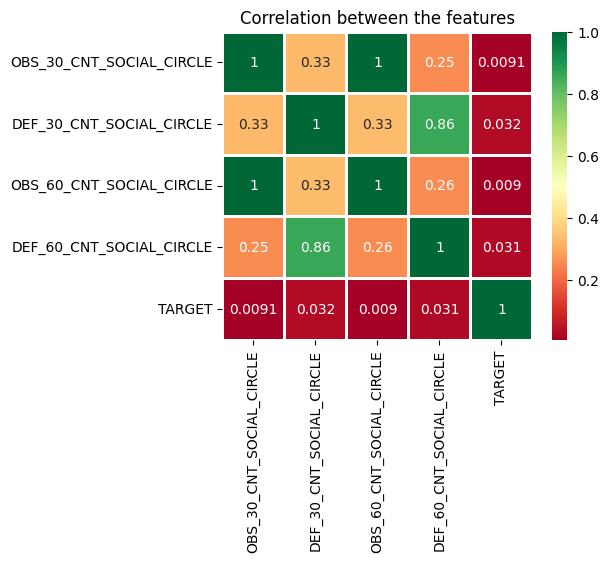

In [304]:
suspect_corr = appData[suspect_col+['TARGET']].corr()

fig = plt.figure(figsize=(5,4))
ax = sns.heatmap(suspect_corr,xticklabels=suspect_corr.columns,yticklabels=suspect_corr.columns,annot = True,cmap ="RdYlGn",linewidth=1)
plt.title("Correlation between the features")
plt.show()

In [305]:
appData.drop(columns = suspect_col, inplace=True)
print(appData.shape)

(307507, 43)


### External Datasource Columns

* These columns are linked to external data sources.
* The columns have a poor correlation with the TARGET variable.
* Will be dropping them.

In [306]:
suspect_col = []
for i in appData.columns:
    if 'EXT' in i:
        suspect_col.append(i)
        print(f"{i}: {defiFnx(i)}")

EXT_SOURCE_1: Normalized score from external data source
EXT_SOURCE_2: Normalized score from external data source
EXT_SOURCE_3: Normalized score from external data source


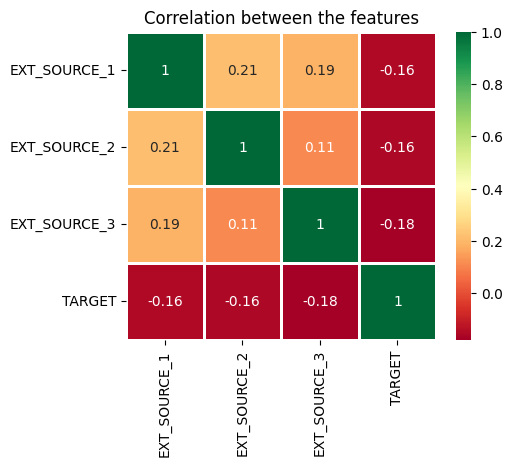

In [307]:
suspect_corr = appData[suspect_col+['TARGET']].corr()

fig = plt.figure(figsize=(5,4))
ax = sns.heatmap(suspect_corr,xticklabels=suspect_corr.columns,yticklabels=suspect_corr.columns,annot = True,cmap ="RdYlGn",linewidth=1)
plt.title("Correlation between the features")
plt.show()

In [308]:
appData.drop(columns = suspect_col, inplace=True)
print(appData.shape)

(307507, 40)


### Fixing Day & Age Related Columns

In [309]:
df=appData.copy()
suspect_col = []
for i in df.columns:
    if 'DAYS' in i:
        suspect_col.append(i)
        print(f"{i}: {defiFnx(i)}")

DAYS_BIRTH: Client's age in days at the time of application
DAYS_REGISTRATION: How many days before the application did client change his registration
DAYS_ID_PUBLISH: How many days before the application did client change the identity document with which he applied for the loan
DAYS_LAST_PHONE_CHANGE: How many days before application did client change phone


In [310]:
%%time
for col in suspect_col:
    appData[col] = (-appData[col]/365).astype('float')

CPU times: user 13.6 ms, sys: 0 ns, total: 13.6 ms
Wall time: 31.8 ms


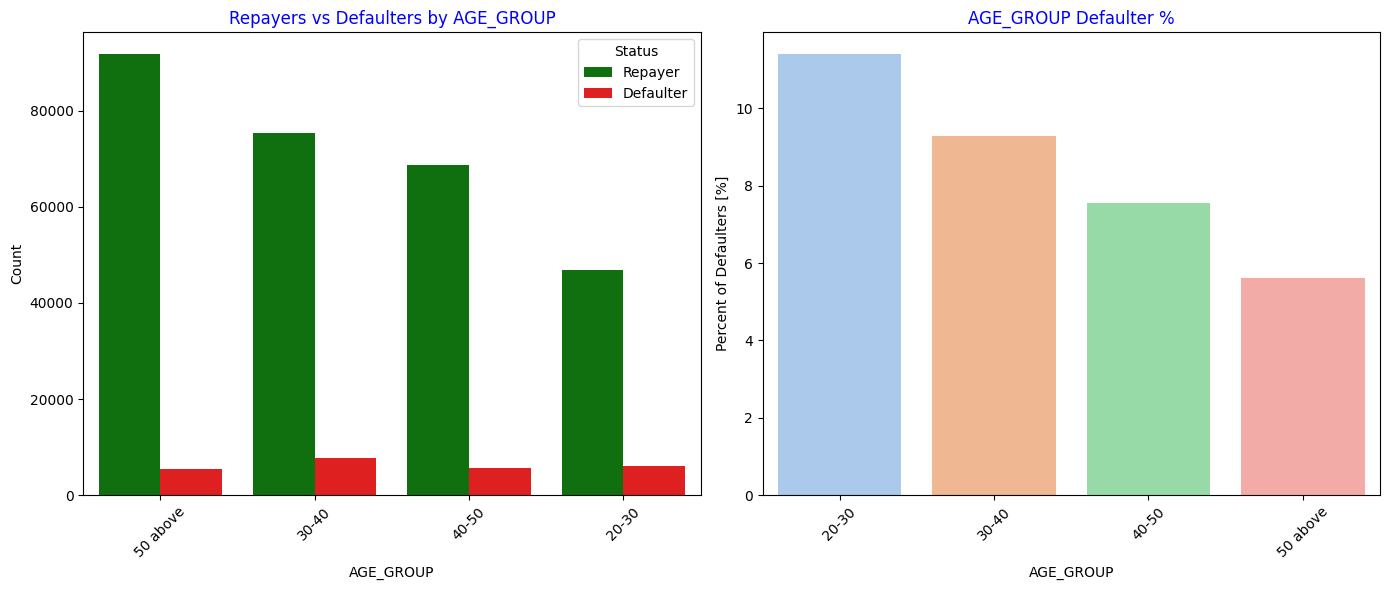

In [311]:
bins = [20,30,40,50,100]
slots = ['20-30','30-40','40-50','50 above']
df['AGE']=np.floor(appData['DAYS_BIRTH'])
df['AGE_GROUP']=pd.cut(df['AGE'],bins=bins,labels=slots)
value_counts = df['AGE_GROUP'].value_counts().index
target_mean = df.groupby('AGE_GROUP')['TARGET'].mean() * 100


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))
sns.countplot(x='AGE_GROUP',
                  data=df,
                  hue='TARGET',
                  order=value_counts,
                  palette=['green', 'red'],
                  ax=ax1)
ax1.set_title("Repayers vs Defaulters by AGE_GROUP", fontsize=12, color='blue')
ax1.set_ylabel("Count", fontsize=10, color='black')
ax1.legend(title='Status', labels=['Repayer', 'Defaulter'])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

sns.barplot(x=target_mean.index,
                y=target_mean.values,
                palette='pastel',
                ax=ax2)
ax2.set_title(f"{'AGE_GROUP'} Defaulter %", fontsize=12, color='blue')
ax2.set_ylabel("Percent of Defaulters [%]", fontsize=10, color='black')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [312]:
appData['OWN_CAR_AGE'].value_counts(dropna=False,normalize=True)

,proportion
OWN_CAR_AGE,
NaN,0.65991
1.0,0.34009


In [313]:
appData.drop(columns = ['OWN_CAR_AGE'],inplace=True)

---
## Columns Under Consideration


In [314]:
print('The shape of dataset after the primary preprocessing stage is as follows:')
print(f'Number of Rows: {appData.shape[0]}, Number of Columns: {appData.shape[1]}')

The shape of dataset after the primary preprocessing stage is as follows:
Number of Rows: 307507, Number of Columns: 39


In [315]:
appData.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,missingData,region,AMT_CREDIT_RANGE,creditB,workExperience,mobileCommunication
0,100002,1,Cash loans,M,N,Y,0,202500.0,4.065975,24700.5,...,0,Business Entity Type 3,3.106849,1,0.819672,2.0,400k-500k,1.0,1.745205,4
1,100003,0,Cash loans,F,N,N,0,270000.0,12.935025,35698.5,...,0,School,2.268493,1,1.639344,1.0,1M Above,0.0,3.254795,4
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,1.350000,6750.0,...,0,Government,2.232877,0,39.344262,2.0,100K-200K,0.0,0.616438,5
3,100006,0,Cash loans,F,N,Y,0,135000.0,3.126825,29686.5,...,0,Business Entity Type 3,1.690411,1,45.901639,2.0,300k-400k,0.0,8.326027,3
4,100007,0,Cash loans,M,N,Y,0,121500.0,5.130000,21865.5,...,1,Religion,3.030137,0,40.983607,2.0,500k-600k,0.0,8.323288,3


In [316]:
appData.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307510
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   307507 non-null  int64   
 1   TARGET                       307507 non-null  int64   
 2   NAME_CONTRACT_TYPE           307507 non-null  object  
 3   CODE_GENDER                  307507 non-null  object  
 4   FLAG_OWN_CAR                 307507 non-null  object  
 5   FLAG_OWN_REALTY              307507 non-null  object  
 6   CNT_CHILDREN                 307507 non-null  int64   
 7   AMT_INCOME_TOTAL             307507 non-null  float64 
 8   AMT_CREDIT                   307507 non-null  float64 
 9   AMT_ANNUITY                  307495 non-null  float64 
 10  AMT_GOODS_PRICE              307229 non-null  float64 
 11  NAME_TYPE_SUITE              306215 non-null  object  
 12  NAME_INCOME_TYPE             307507 non-null  obj

In [317]:
appData.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,...,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,missingData,region,creditB,workExperience,mobileCommunication
count,307507.000000,307507.00000,307507.000000,3.075070e+05,307507.000000,307495.000000,3.072290e+05,307507.000000,307507.000000,307507.000000,...,307507.000000,307507.000000,307507.000000,307506.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000
mean,278181.527256,0.08073,0.417047,1.687977e+05,5.990286,27108.666786,5.383977e+05,0.020868,43.937061,13.660634,...,0.078174,0.230457,0.179557,2.637974,0.710033,24.396051,2.041989,2.145655,5.355672,3.355153
std,102790.132982,0.27242,0.722119,2.371246e+05,4.024926,14493.798379,3.694472e+05,0.013831,11.956116,9.651734,...,0.268445,0.421126,0.383819,2.265237,0.453748,17.147006,0.499630,2.290849,6.320649,0.865273
min,100002.000000,0.00000,0.000000,2.565000e+04,0.450000,1615.500000,4.050000e+04,0.000290,20.517808,-0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,189146.500000,0.00000,0.000000,1.125000e+05,2.700000,16524.000000,2.385000e+05,0.010006,34.008219,5.506849,...,0.000000,0.000000,0.000000,0.750685,0.000000,4.098361,2.000000,0.000000,0.791781,3.000000
50%,278203.000000,0.00000,0.000000,1.471500e+05,5.135310,24903.000000,4.500000e+05,0.018850,43.150685,12.339726,...,0.000000,0.000000,0.000000,2.073973,1.000000,29.508197,2.000000,2.000000,3.323288,3.000000
75%,367143.500000,0.00000,1.000000,2.025000e+05,8.086500,34596.000000,6.795000e+05,0.028663,53.923288,20.491781,...,0.000000,0.000000,0.000000,4.301370,1.000000,40.163934,2.000000,3.000000,7.561644,4.000000
max,456255.000000,1.00000,19.000000,1.170000e+08,40.500000,258025.500000,4.050000e+06,0.072508,69.120548,67.594521,...,1.000000,1.000000,1.000000,11.758904,1.000000,50.000000,3.000000,262.000000,49.073973,6.000000


**Primary Preprocessing Complete**

---


## Secondary Preprocessing

In this stage, we will perform the following preprocessing tasks:

- **Handle missing values**: Impute or remove missing data based on feature type.
- **Scale/Normalize continuous variables**: Apply standardization (e.g., Z-score) or normalization (e.g., Min-Max scaling) for continuous features.
- **Encode categorical variables**: Use one-hot encoding or label encoding to convert categorical features into numerical format.
- **Outlier detection and treatment**: Identify and handle outliers using methods like Z-score or IQR.

These steps aim to transform the data into a suitable format for modeling.


In [318]:
appData['NAME_CONTRACT_TYPE'].replace({'Cash loans':'cash','Revolving loans':'revolve'},inplace=True)

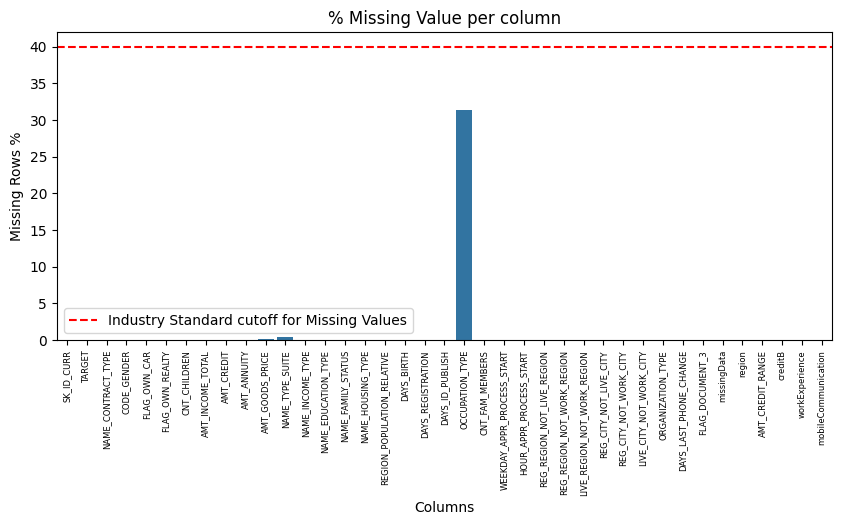

In [319]:
plt.figure(figsize=(10,4),dpi=100)
sns.barplot(data=appData.isna().mean()*100)
plt.axhline(y=40,color='red',linestyle = '--',label='Industry Standard cutoff for Missing Values')
plt.legend()
plt.xticks(rotation=90,fontsize=6)
plt.title('% Missing Value per column')
plt.xlabel('Columns')
plt.ylabel('Missing Rows %')
plt.show()

In [320]:
appData.isna().sum()

,0
SK_ID_CURR,0
TARGET,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,12


### Occupation Type
We can replace the NaN with 'Unknown'

In [321]:
defiFnx('OCCUPATION_TYPE')

'What kind of occupation does the client have'

In [322]:
appData['OCCUPATION_TYPE'].value_counts(dropna = False)

,count
OCCUPATION_TYPE,
NaN,96389
Laborers,55186
Sales staff,32102
Core staff,27569
Managers,21371
Drivers,18603
High skill tech staff,11380
Accountants,9813
Medicine staff,8537


In [323]:
appData['OCCUPATION_TYPE'].fillna(value = 'Unkown',inplace=True)

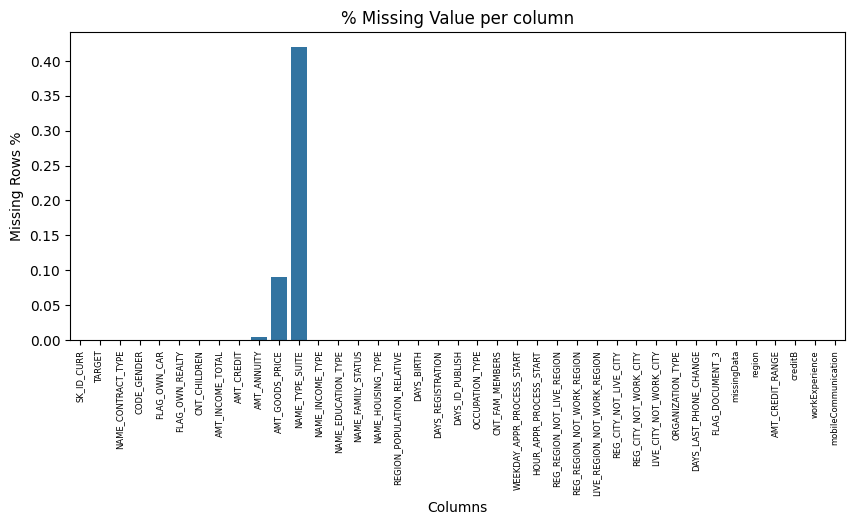

In [324]:
plt.figure(figsize=(10,4),dpi=100)
sns.barplot(data=appData.isna().mean()*100)
plt.xticks(rotation=90,fontsize=6)
plt.title('% Missing Value per column')
plt.xlabel('Columns')
plt.ylabel('Missing Rows %')
plt.show()

### Application Attendance
* We will merge Family, Spouse/Partner and Children into a single category
* We will merge OtherA/B, Group and NaN into others
* The rest remains the same

In [325]:
defiFnx('NAME_TYPE_SUITE')

'Who was accompanying client when he was applying for the loan'

In [326]:
appData['NAME_TYPE_SUITE'].value_counts(dropna=False,normalize=True)

,proportion
NAME_TYPE_SUITE,
Unaccompanied,0.808186
Family,0.130560
"Spouse, partner",0.036975
Children,0.010624
Other_B,0.005756
NaN,0.004202
Other_A,0.002816
Group of people,0.000881


In [327]:
appData['NAME_TYPE_SUITE'].replace(to_replace=['Spouse, partner','Children'],value='Family',inplace=True)
appData['NAME_TYPE_SUITE'].replace(to_replace=['Other_A', 'Other_B','Group of people'],value='Others',inplace=True)
appData['NAME_TYPE_SUITE'].fillna('Others',inplace=True)

appData['NAME_TYPE_SUITE'].value_counts(dropna=False,normalize=True)

,proportion
NAME_TYPE_SUITE,
Unaccompanied,0.808186
Family,0.178159
Others,0.013655


### Goods Price
* Will be replaced by the mean value of the distribution

In [328]:
defiFnx('AMT_GOODS_PRICE')

'For consumer loans it is the price of the goods for which the loan is given'

In [329]:
appData['AMT_GOODS_PRICE'].isna().sum()

278

In [330]:
appData['AMT_GOODS_PRICE'].describe()

,AMT_GOODS_PRICE
count,3.072290e+05
mean,5.383977e+05
std,3.694472e+05
min,4.050000e+04
25%,2.385000e+05
50%,4.500000e+05
75%,6.795000e+05
max,4.050000e+06


In [331]:
appData['AMT_GOODS_PRICE'].interpolate(inplace=True)
appData['AMT_GOODS_PRICE'].isna().sum()

0

In [332]:
tt = appData.isna().sum()
tt[tt>0]

,0
AMT_ANNUITY,12
CNT_FAM_MEMBERS,2
DAYS_LAST_PHONE_CHANGE,1


### Family Member Count, Annuity & Phone Change
* We can drop the rows belonging to these columns and are NaN.
* Annunity is an important parameter in loan systems.
* The remaining columns are more or less insignificant for the target column and miniscule in number.


In [333]:
appData.dropna(inplace=True)

In [334]:
appData.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 307492 entries, 0 to 307510
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   307492 non-null  int64   
 1   TARGET                       307492 non-null  int64   
 2   NAME_CONTRACT_TYPE           307492 non-null  object  
 3   CODE_GENDER                  307492 non-null  object  
 4   FLAG_OWN_CAR                 307492 non-null  object  
 5   FLAG_OWN_REALTY              307492 non-null  object  
 6   CNT_CHILDREN                 307492 non-null  int64   
 7   AMT_INCOME_TOTAL             307492 non-null  float64 
 8   AMT_CREDIT                   307492 non-null  float64 
 9   AMT_ANNUITY                  307492 non-null  float64 
 10  AMT_GOODS_PRICE              307492 non-null  float64 
 11  NAME_TYPE_SUITE              307492 non-null  object  
 12  NAME_INCOME_TYPE             307492 non-null  obj

In [335]:
appData.drop(columns=['AMT_CREDIT_RANGE'],inplace=True)

In [336]:
appData.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 307492 entries, 0 to 307510
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307492 non-null  int64  
 1   TARGET                       307492 non-null  int64  
 2   NAME_CONTRACT_TYPE           307492 non-null  object 
 3   CODE_GENDER                  307492 non-null  object 
 4   FLAG_OWN_CAR                 307492 non-null  object 
 5   FLAG_OWN_REALTY              307492 non-null  object 
 6   CNT_CHILDREN                 307492 non-null  int64  
 7   AMT_INCOME_TOTAL             307492 non-null  float64
 8   AMT_CREDIT                   307492 non-null  float64
 9   AMT_ANNUITY                  307492 non-null  float64
 10  AMT_GOODS_PRICE              307492 non-null  float64
 11  NAME_TYPE_SUITE              307492 non-null  object 
 12  NAME_INCOME_TYPE             307492 non-null  object 
 13  NAME

### Treating Categorical Variables
Treating categorical variables is essential because most machine learning algorithms require numerical input to make predictions.

Techniques like one-hot encoding create binary columns for each category, while label encoding assigns a unique integer to each category, both enabling models to interpret categorical data effectively.
* Categorical variables with less than 3 unique values will be processed with OneHotEncoding
* The rest will be LabelEncoded

In [337]:
appData.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,missingData,region,creditB,workExperience,mobileCommunication
0,100002,1,cash,M,N,Y,0,202500.0,4.065975,24700.5,...,0,0,Business Entity Type 3,3.106849,1,0.819672,2.0,1.0,1.745205,4
1,100003,0,cash,F,N,N,0,270000.0,12.935025,35698.5,...,0,0,School,2.268493,1,1.639344,1.0,0.0,3.254795,4
2,100004,0,revolve,M,Y,Y,0,67500.0,1.350000,6750.0,...,0,0,Government,2.232877,0,39.344262,2.0,0.0,0.616438,5
3,100006,0,cash,F,N,Y,0,135000.0,3.126825,29686.5,...,0,0,Business Entity Type 3,1.690411,1,45.901639,2.0,0.0,8.326027,3
4,100007,0,cash,M,N,Y,0,121500.0,5.130000,21865.5,...,1,1,Religion,3.030137,0,40.983607,2.0,0.0,8.323288,3


In [338]:
oneHotCol,labelEncCol = [],[]
for col,col_d in zip(appData.columns,appData.dtypes):
    if col_d == 'object':
        print(f"Column Name: {col}, Num Unique Values: {appData[col].nunique()}")
        if appData[col].nunique()<3:
            oneHotCol.append(col)
        else:
            labelEncCol.append(col)

Column Name: NAME_CONTRACT_TYPE, Num Unique Values: 2
Column Name: CODE_GENDER, Num Unique Values: 2
Column Name: FLAG_OWN_CAR, Num Unique Values: 2
Column Name: FLAG_OWN_REALTY, Num Unique Values: 2
Column Name: NAME_TYPE_SUITE, Num Unique Values: 3
Column Name: NAME_INCOME_TYPE, Num Unique Values: 8
Column Name: NAME_EDUCATION_TYPE, Num Unique Values: 5
Column Name: NAME_FAMILY_STATUS, Num Unique Values: 5
Column Name: NAME_HOUSING_TYPE, Num Unique Values: 6
Column Name: OCCUPATION_TYPE, Num Unique Values: 19
Column Name: WEEKDAY_APPR_PROCESS_START, Num Unique Values: 7
Column Name: ORGANIZATION_TYPE, Num Unique Values: 58


In [339]:
print(f"Columns for Label Encoding: {labelEncCol}\n")
print(f"Columns for OneHot Encoding: {oneHotCol}")


Columns for Label Encoding: ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']

Columns for OneHot Encoding: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


#### Label Encoding

In [340]:
encoderMap = defaultdict(LabelEncoder)

In [341]:
appData[labelEncCol] = appData[labelEncCol].apply(lambda x: encoderMap[x.name].fit_transform(x))

In [342]:
# # To inverse transform the encoding.
# appData[labelEncCol].apply(lambda x: encoderMap[x.name].inverse_transform(x))

#### OneHot Encoding

In [343]:
from sklearn.preprocessing import OneHotEncoder

In [344]:
data = pd.get_dummies(appData,columns=oneHotCol,prefix=['Contract','GENDER','CAR','REALTY'],dtype=float)
# --- Variable Reset Tag

**Secondary Preprocessing Complete**

---


In [345]:
print('The shape of dataset after the data preprocessing stage is as follows:')
print(f'Number of Rows: {data.shape[0]}, Number of Columns: {data.shape[1]}')

The shape of dataset after the data preprocessing stage is as follows:
Number of Rows: 307492, Number of Columns: 42


In [346]:
appData_class0=appData[appData['TARGET']==0]
x=appData.drop(columns=['TARGET','SK_ID_CURR'])
y=appData['TARGET']

In [347]:
oneHotCol,labelEncCol = [],[]
for col,col_d in zip(appData.columns,appData.dtypes):
    if col_d == 'object':
        print(f"Column Name: {col}, Num Unique Values: {appData[col].nunique()}")
        if appData[col].nunique()<3:
            oneHotCol.append(col)
        else:
            labelEncCol.append(col)
encoderMap = defaultdict(LabelEncoder)
appData[labelEncCol] = appData[labelEncCol].apply(lambda x: encoderMap[x.name].fit_transform(x))
from sklearn.preprocessing import OneHotEncoder
data = pd.get_dummies(appData,columns=oneHotCol,prefix=['Contract','GENDER','CAR','REALTY'],dtype=float)

Column Name: NAME_CONTRACT_TYPE, Num Unique Values: 2
Column Name: CODE_GENDER, Num Unique Values: 2
Column Name: FLAG_OWN_CAR, Num Unique Values: 2
Column Name: FLAG_OWN_REALTY, Num Unique Values: 2


## Classification Algorithms

In [348]:
xdata = data.iloc[:,2:]
ydata = data.iloc[:,1]

scaler = StandardScaler()
xdata_scaled = scaler.fit_transform(xdata)

xtrain,xtest,ytrain,ytest = train_test_split(xdata,ydata,test_size=0.2,random_state=42)

### Tree Series

In [349]:
# %%time
# Random Forest Depth 5
clf = RandomForestClassifier(max_depth=5, random_state=0).fit(xtrain,ytrain)
ypred = clf.predict(xtest)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56474
           1       0.00      0.00      0.00      5025

    accuracy                           0.92     61499
   macro avg       0.46      0.50      0.48     61499
weighted avg       0.84      0.92      0.88     61499



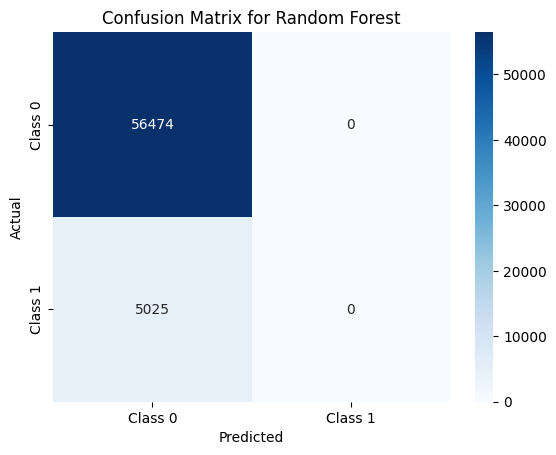

In [350]:
print(classification_report(ytest,ypred))

cm = confusion_matrix(ytest, ypred, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest")
plt.show()

### XGBoost Algorithm

In [351]:
import xgboost as xgb

In [352]:
clf = xgb.XGBClassifier(n_estimators = 200,max_depth=20).fit(xtrain,ytrain)
ypred = clf.predict(xtest)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56474
           1       0.35      0.01      0.02      5025

    accuracy                           0.92     61499
   macro avg       0.63      0.50      0.49     61499
weighted avg       0.87      0.92      0.88     61499



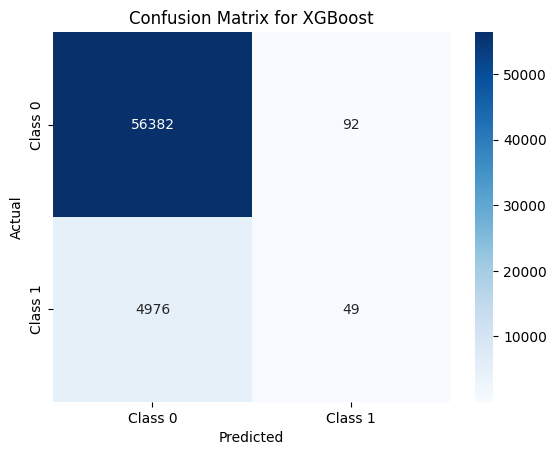

In [353]:
print(classification_report(ytest,ypred))

cm = confusion_matrix(ytest, ypred, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBoost")
plt.show()

### CatBoost Algorithm

In [354]:
xtrain,xtest,ytrain,ytest = train_test_split(xdata,ydata,test_size=0.2,random_state=42)

In [355]:
# %%time
catboost_model = CatBoostClassifier(iterations=300, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=100,scale_pos_weight=5)
catboost_model.fit(xtrain, ytrain, eval_set=(xtest, ytest), early_stopping_rounds=50)

0:	learn: 0.6829535	test: 0.6831591	best: 0.6831591 (0)	total: 170ms	remaining: 50.8s
100:	learn: 0.5658870	test: 0.5718527	best: 0.5718527 (100)	total: 8.84s	remaining: 17.4s
200:	learn: 0.5582064	test: 0.5678698	best: 0.5678698 (200)	total: 18.6s	remaining: 9.18s
299:	learn: 0.5514722	test: 0.5653553	best: 0.5653553 (299)	total: 26.5s	remaining: 0us

bestTest = 0.5653553076
bestIteration = 299



              precision    recall  f1-score   support

           0       0.93      0.94      0.94     56474
           1       0.24      0.20      0.22      5025

    accuracy                           0.88     61499
   macro avg       0.59      0.57      0.58     61499
weighted avg       0.87      0.88      0.88     61499



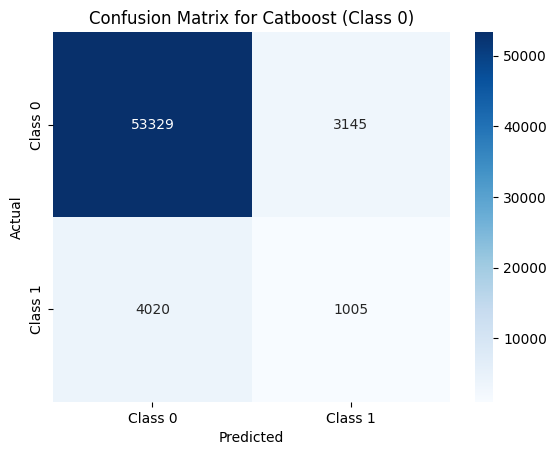

In [356]:
catboost_pred = catboost_model.predict(xtest)
catboost_probs = catboost_model.predict_proba(xtest)
cm = confusion_matrix(ytest, catboost_pred, labels=[0, 1])

print(classification_report(ytest,catboost_pred))

sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Catboost (Class 0)")
plt.show()

In [357]:
from sklearn.metrics import precision_recall_curve,accuracy_score,precision_score,recall_score,f1_score

print(accuracy_score(ytest,catboost_pred))
print(precision_score(ytest,catboost_pred,average='binary',pos_label=0))
print(recall_score(ytest,catboost_pred,pos_label=0))
print(f1_score(ytest,catboost_pred,pos_label=0))

0.8834940405535049
0.9299028753770772
0.944310656231186
0.9370513868023159


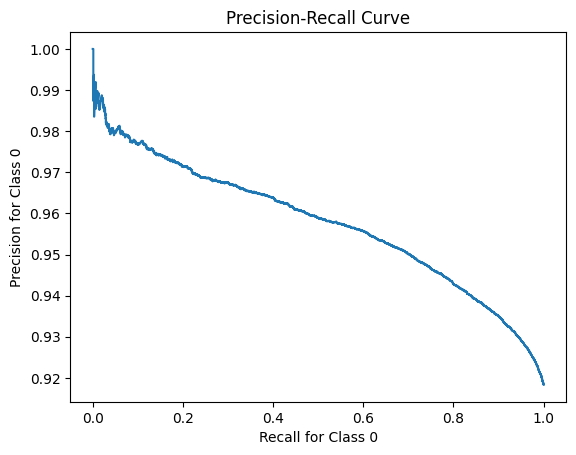

In [358]:
from sklearn.metrics import precision_recall_curve

y_pred_prob = catboost_model.predict_proba(xtest)[:, 0]  # Probabilities for Class 0
precision, recall, thresholds = precision_recall_curve(ytest, y_pred_prob, pos_label=0)

plt.plot(recall, precision)
plt.xlabel("Recall for Class 0")
plt.ylabel("Precision for Class 0")
plt.title("Precision-Recall Curve")
plt.show()


## Minority Class Identification - One Class
Building a minority class identification model for a highly imbalanced dataset is important to address the potential bias towards the majority class, ensuring the model can accurately predict the underrepresented class.

### One Class SVM

In [368]:

xdata = data.iloc[:,2:]
ydata = data.iloc[:,1]

scaler = StandardScaler()
# xdata_scaled = scaler.fit_transform(xdata)

xtrain,xtest,ytrain,ytest = train_test_split(xdata,ydata,test_size=0.2,random_state=42)

idx = ytrain[ytrain == 1].index
xtrainOneClass = xdata.loc[idx]

xtrainOC_Scaled = scaler.fit_transform(xtrainOneClass)
xtest_scaled = scaler.transform(xtest)

# RBF Kernel
svm_model = OneClassSVM(kernel='rbf', gamma='auto').fit(xtrainOC_Scaled)

# Predicting on test data
svm_scores = svm_model.decision_function(xtest_scaled)
svm_pred = svm_model.predict(xtest_scaled)
svm_pred[svm_pred == -1] = 0


In [369]:

print(classification_report(ytest, svm_pred))

              precision    recall  f1-score   support

           0       0.93      0.58      0.71     56474
           1       0.10      0.50      0.16      5025

    accuracy                           0.57     61499
   macro avg       0.51      0.54      0.44     61499
weighted avg       0.86      0.57      0.67     61499



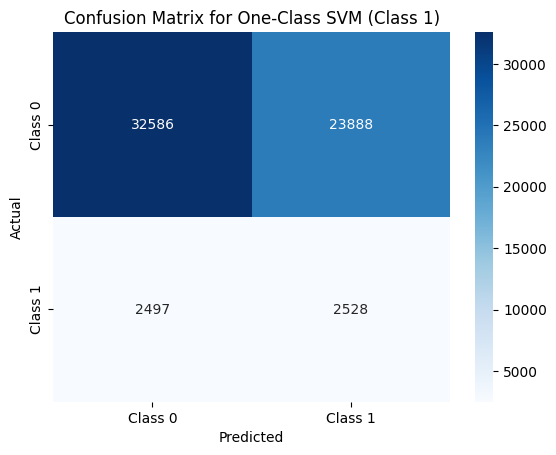

In [370]:
cm = confusion_matrix(ytest, svm_pred, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for One-Class SVM (Class 1)")
plt.show()

In [371]:
print(accuracy_score(ytest,svm_pred))
print(precision_score(ytest,svm_pred,average='binary'))
print(recall_score(ytest,svm_pred,pos_label=1))
print(f1_score(ytest,svm_pred,pos_label=1))

0.5709686336363193
0.09569957601453664
0.5030845771144279
0.16080913456951115


## Meta Model

Creation of a meta-model that combines CatBoost, a powerful gradient boosting algorithm, with a One-Class SVM to tackle the imbalanced dataset classification task.
* The CatBoost model handles the predictive task, while the One-Class SVM focuses on identifying the minority class.
* This hybrid approach improves overall model performance by addressing class imbalance and enhancing detection of the underrepresented class.

In [372]:
from sklearn.ensemble import RandomForestClassifier
meta_model = RandomForestClassifier(random_state=42)


meta_features = np.column_stack((
    catboost_probs[:, 1],  # Probability of Class 1 from CatBoost
    svm_scores             # Decision scores from One-Class SVM
))
meta_labels = ytest


### Meta Model Evaluation

In [373]:
# %%time
# Add additional meta-features
# Meta-feature 1: Confidence difference from CatBoost
confidence_catboost = np.abs(catboost_probs[:, 0] - catboost_probs[:, 1])

# Meta-feature 2: Combined score (average of CatBoost probability and SVM score)
combined_scores = (catboost_probs[:, 1] + svm_scores) / 2

# Meta-feature 3: Agreement between CatBoost and SVM predictions
agreement = (catboost_pred == svm_pred).astype(int)

# Meta-feature 4: Distance from decision boundary in SVM
svm_confidence = np.abs(svm_scores)

# Create meta-features for training the meta-classifier
meta_features = np.column_stack((
    catboost_probs[:, 1],  # Probability of Class 1 from CatBoost
    svm_scores,             # Decision scores from One-Class SVM
    confidence_catboost,    # Confidence from CatBoost
    combined_scores,        # Combined score
    agreement,              # Agreement between models
    svm_confidence          # SVM decision boundary distance
))

meta_labels = ytest

# Create meta-features for testing the meta-classifier
meta_features_test = np.column_stack((
    catboost_probs[:, 1],
    svm_scores,
    confidence_catboost,
    combined_scores,
    agreement,
    svm_confidence
))

# Train a meta-classifier
meta_model = RandomForestClassifier(random_state=42)
meta_model.fit(meta_features, meta_labels)
meta_decisions = meta_model.predict(meta_features_test)

# Final combined predictions
final_predictions = []
for i in range(len(xtest)):
    if meta_decisions[i] == 1:  # Meta-classifier suggests using SVM for Class 1
        final_predictions.append(svm_pred[i])
    else:  # Meta-classifier suggests using CatBoost
        final_predictions.append(catboost_pred[i])

              precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95     56474
     Class 1       0.45      0.50      0.47      5025

    accuracy                           0.91     61499
   macro avg       0.70      0.72      0.71     61499
weighted avg       0.91      0.91      0.91     61499



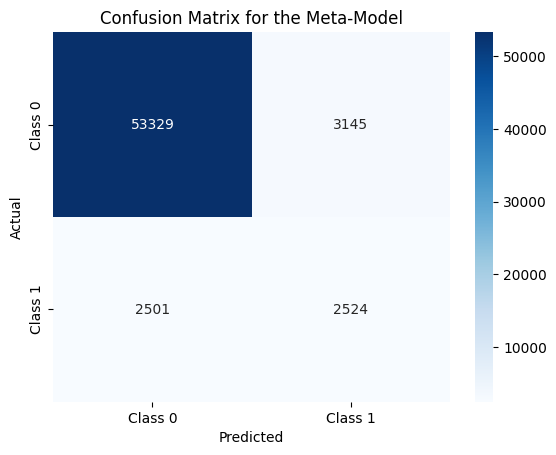

In [374]:
# Evaluate combined predictions
print(classification_report(ytest, final_predictions, target_names=["Class 0", "Class 1"]))
cm = confusion_matrix(ytest, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the Meta-Model")
plt.show()

In [375]:
print("Combined Model - Classification Report")
print(classification_report(ytest, final_predictions, target_names=["Class 0", "Class 1"]))

Combined Model - Classification Report
              precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95     56474
     Class 1       0.45      0.50      0.47      5025

    accuracy                           0.91     61499
   macro avg       0.70      0.72      0.71     61499
weighted avg       0.91      0.91      0.91     61499



Combined Model AUC-ROC: 1.0000


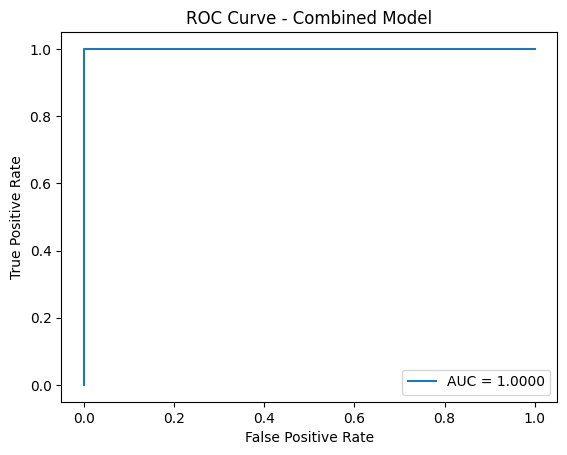

In [111]:
from sklearn.metrics import roc_auc_score, roc_curve

# Probability for Class 1 (from the combined decision)
# meta_features_test = np.column_stack((catboost_probs[:, 1], svm_scores))
meta_decisions = meta_model.predict_proba(meta_features_test)[:, 1]

# Compute AUC-ROC
auc = roc_auc_score(ytest, meta_decisions)
print(f"Combined Model AUC-ROC: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(ytest, meta_decisions)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Combined Model")
plt.legend(loc="lower right")
plt.show()


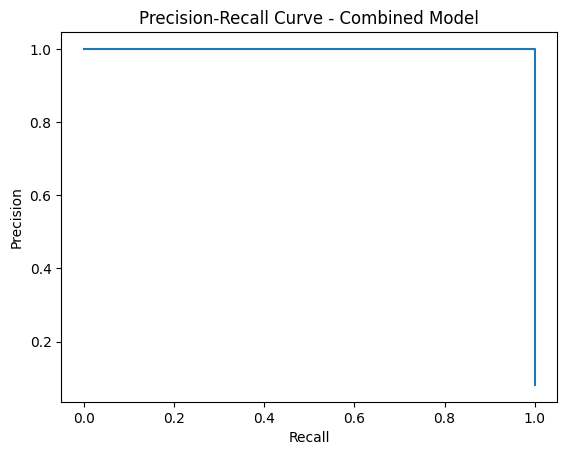

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(ytest, meta_decisions)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Combined Model")
plt.show()


## Comparison of Individual Models with MetaModel
When comparing the individual models to the meta-model, the combined CatBoost and One-Class SVM approach outperforms each model alone in handling class imbalance. The meta-model demonstrates improved accuracy in detecting the minority class and overall predictive performance.

In [ ]:
print("CatBoost Classification Report")
print(classification_report(ytest, catboost_pred, target_names=["Class 0", "Class 1"]))

CatBoost Classification Report
              precision    recall  f1-score   support

     Class 0       0.93      0.94      0.94     56474
     Class 1       0.24      0.20      0.22      5025

    accuracy                           0.88     61499
   macro avg       0.59      0.57      0.58     61499
weighted avg       0.87      0.88      0.88     61499



In [ ]:
print("One-Class SVM Classification Report")
print(classification_report(ytest, svm_pred, target_names=["Class 0", "Class 1"]))


One-Class SVM Classification Report
              precision    recall  f1-score   support

     Class 0       0.93      0.58      0.71     56474
     Class 1       0.10      0.50      0.16      5025

    accuracy                           0.57     61499
   macro avg       0.51      0.54      0.44     61499
weighted avg       0.86      0.57      0.67     61499



In [ ]:
print("Meta Model Classification Report")
print(classification_report(ytest, final_predictions, target_names=["Class 0", "Class 1"]))

Meta Model Classification Report
              precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95     56474
     Class 1       0.45      0.50      0.47      5025

    accuracy                           0.91     61499
   macro avg       0.70      0.72      0.71     61499
weighted avg       0.91      0.91      0.91     61499

